<a href="https://colab.research.google.com/github/amir-jafari/SOM/blob/main/examples/NNSOM_NND_Ch26_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade NNSOM

Importing Libraries

In [2]:
from NNSOM.som import SOM
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
from numpy.random import default_rng
import matplotlib.pyplot as plt
import os

Path Setting

In [6]:
from google.colab import drive
drive.mount('/content/drive')

abs_path = '/content/drive/MyDrive/Colab Notebooks/DATS6501_Capstone/Examples/'
data_path = abs_path + 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set Parameters

In [7]:
# Set parameters
SOM_Row_Num = 10
SOM_Col_Num = 15

Dimensions = (SOM_Row_Num, SOM_Col_Num)
Epochs = 500
Steps = 100
Init_neighborhood = 3
SEED = 1234567
rng = default_rng(SEED)


Data Collection and Preprocessing

In [8]:
# Loading data
with open(data_path + 'cover_p.txt', 'r') as f:
    data = f.readlines()
    data = [list(map(float, x.strip().split())) for x in data]

with open(data_path + 'cover_t.txt', 'r') as f:
    target = f.readlines()
    target = [list(map(float, x.strip().split())) for x in target]

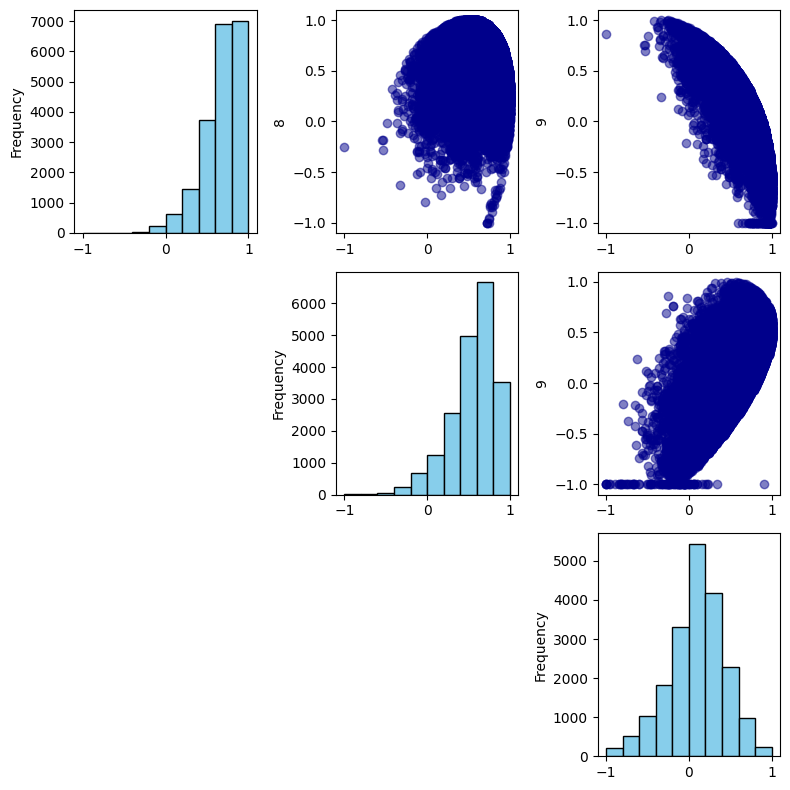

In [9]:
# Convert to numpy array
data = np.array(data)

# Normalize the data from -1 to 1 with standardization
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Create Subplots for the input variables
df = pd.DataFrame(data[:, 6:9], columns=['7', '8', '9'])
n = len(df.columns)
fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))
# Loop through rows
for i in range(n):
    # Loop through columns
    for j in range(n):
        # Hide lower triangle and diagonal
        if i > j:
            axes[i, j].axis('off')
        # Diagonal: plot histograms
        if i == j:
            axes[i, j].hist(df[df.columns[i]], bins=10, color='skyblue', edgecolor='black')
            axes[i, j].set_ylabel('Frequency')
        # Upper triangle: plot scatter
        if i < j:
            axes[i, j].scatter(df[df.columns[i]], df[df.columns[j]], alpha=0.5, color='darkblue')
            axes[j, i].set_xlabel(df.columns[i])  # Set x-axis label for corresponding lower triangle plot
            axes[i, j].set_ylabel(df.columns[j])  # Set y-axis label
plt.tight_layout()
plt.show()

In [10]:
tot_num = len(data)

# Randomize to get different results
X = data[rng.permutation(tot_num)]

# Initializing can take a long time for large datasets
# Reduce size here. X1 is used for initialization, X is used for training.
X1 = X[:int(tot_num/8)]
X1 = np.transpose(X1)

X = np.transpose(X)

In [11]:
# Train the NETWORK
som_net = SOM(Dimensions)
som_net.init_w(X1)
som_net.train(X, Init_neighborhood, Epochs, Steps)

Beginning Initialization
Current Time = 22:16:01
Ending Initialization
Current Time = 22:16:02
Beginning Training
Current Time = 22:16:02
50
Current Time = 22:16:28
100
Current Time = 22:16:45
150
Current Time = 22:17:00
200
Current Time = 22:17:12
250
Current Time = 22:17:26
300
Current Time = 22:17:40
350
Current Time = 22:17:52
400
Current Time = 22:18:04
450
Current Time = 22:18:13
500
Current Time = 22:18:25
Ending Training
Current Time = 22:18:25


Validation

In [12]:
# Compute statistics
# Distance between each input and each unit
x_w_dist = cdist(som_net.w, np.transpose(X), 'euclidean')

# Find the index of the weight closest to the input
ind1 = np.argmin(x_w_dist, axis=0)

shapw = som_net.w.shape
S = shapw[0]
shapx = X.shape
Q = shapx[1]
net_ones = np.ones(S)
same_size = 100*np.ones(S)

Clust = []
dist = []
mdist = np.zeros(S)
clustSize = []

for i in range(S):
    # Find which inputs are closest to each weight (in cluster i)
    tempclust = np.where(ind1 == i)[0]

    # Save distance of each input in the cluster to cluster center (weight)
    tempdist = x_w_dist[i, tempclust]
    indsort = np.argsort(tempdist)
    tempclust = tempclust[indsort]  # Sort indices
    tempdist = tempdist[indsort]

    # Add to distance array sorted distances
    dist.append(tempdist)

    # Add to Cluster array sorted indices
    Clust.append(tempclust)

    # Cluster size
    num = len(tempclust)
    clustSize.append(num)

    # Save the maximum distance to any input in the cluster from cluster center
    if num > 0:
        mdist[i] = tempdist[-1]

# Find quantization error
quant_err = np.array([0 if len(item) == 0 else np.mean(item) for item in dist]).mean()
print('Quantization error: ' + str(quant_err))

# Topological Error - Percent inputs where the closest center and next closest center are not adjacent
ndist = som_net.neuron_dist
sort_dist = np.argsort(x_w_dist, axis=0)
top_dist = [ndist[sort_dist[0, ii], sort_dist[1, ii]] for ii in range(sort_dist.shape[1])]
neighbors = np.where(np.array(top_dist) > 1.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st neighbor) = ' + str(top_error) + '%')
neighbors = np.where(np.array(top_dist) > 2.1)
top_error = 100*len(neighbors[0])/x_w_dist.shape[1]
print('Topological Error (1st and 2nd neighbor) = ' + str(top_error) + '%')

# Distortion
dd = [1, 2, 3] # neighborhood distances
ww = som_net.w
wwdist = cdist(ww, ww, 'euclidean')
sst = ndist[:, ind1]
for d in dd:
    factor1 = 2*d*d
    factor2 = Q*d*np.sqrt(2*np.pi)
    temp = np.exp(-np.multiply(sst, sst)/factor1)
    distortion = np.sum(np.multiply(temp, x_w_dist))/factor2
    print('Distortion (d='+str(d)+') = ' + str(distortion))

Quantization error: 0.4515288482792752
Topological Error (1st neighbor) = 17.435%
Topological Error (1st and 2nd neighbor) = 3.705%
Distortion (d=1) = 2.067018796133159
Distortion (d=2) = 4.771006001608843
Distortion (d=3) = 7.265600874728445


Plot

/usr/local/lib/python3.10/dist-packages/NNSOM/som.py:1015: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(ticktext)


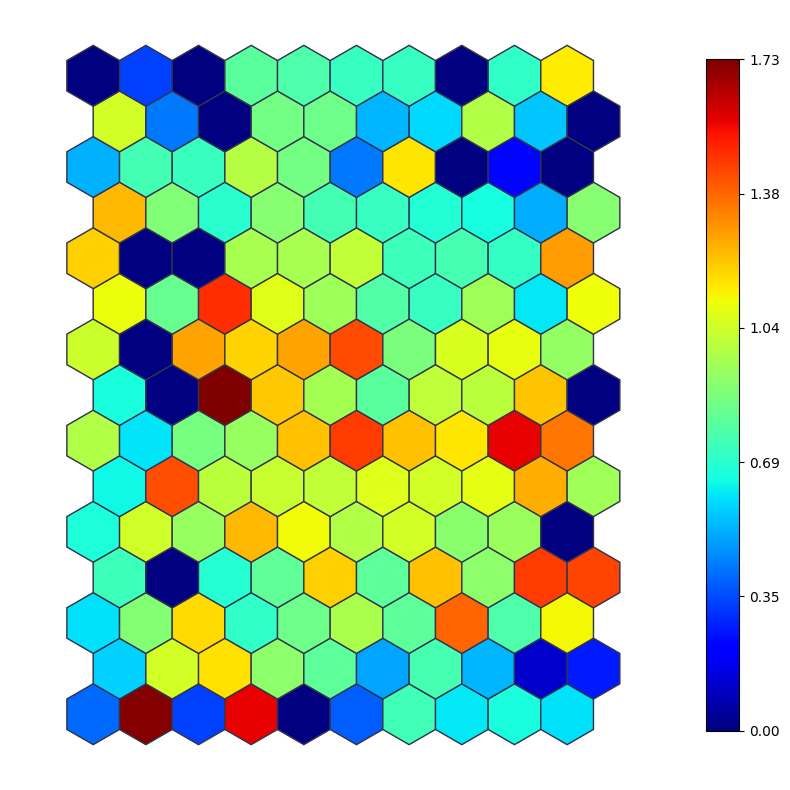

In [13]:
# Plot the SOM
# U-Matrix for Trained SOM
fig11, ax11, pathces, cbar = som_net.simple_grid(mdist, net_ones)
plt.show()

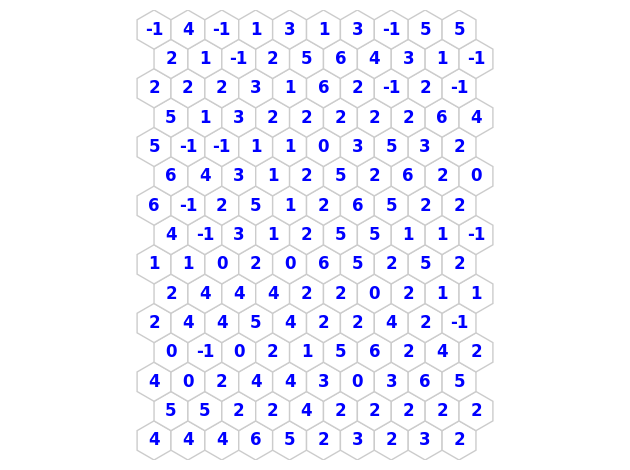

In [15]:
# Labeled SOM
# Assign label of closest input to each weight
# plt_top_labeled(target, dist)
closest_input_index = [item[0] if len(item) > 0 else -1 for item in Clust]
cluster_labels = [target[item] if item != -1 else -1 for item in closest_input_index]
converted_labels = [str(int(x[0]) if isinstance(x, list) else x) for x in cluster_labels]

w = som_net.w
pos = som_net.pos
numNeurons = som_net.numNeurons
z = np.sqrt(0.75)
shapex = np.array([-1, 0, 1, 1, 0, -1]) * 0.5
shapey = np.array([1, 2, 1, -1, -2, -1]) * (z / 3)

fig12, ax12 = plt.subplots(frameon=False)
ax12.axis('off')
plt.axis('equal')
xmin = np.min(pos[0]) + np.min(shapex)
xmax = np.max(pos[0]) + np.max(shapex)
ymin = np.min(pos[1]) + np.min(shapey)
ymax = np.max(pos[1]) + np.max(shapey)
ax12.set_xlim([xmin, xmax])
ax12.set_ylim([ymin, ymax])

patches = []
for i in range(numNeurons):
    temp = plt.fill(pos[0, i] + shapex, pos[1, i] + shapey, facecolor=(1, 1, 1), edgecolor=(0.8, 0.8, 0.8))
    patches.append(temp)

text = []
for i in range(numNeurons):
    temp = plt.text(pos[0, i], pos[1, i], converted_labels[i], horizontalalignment='center', verticalalignment='center', color='b')
    temp._fontproperties._weight = 'bold'
    temp._fontproperties._size = 12.0
    text.append(temp)

fig12.tight_layout()
plt.show()

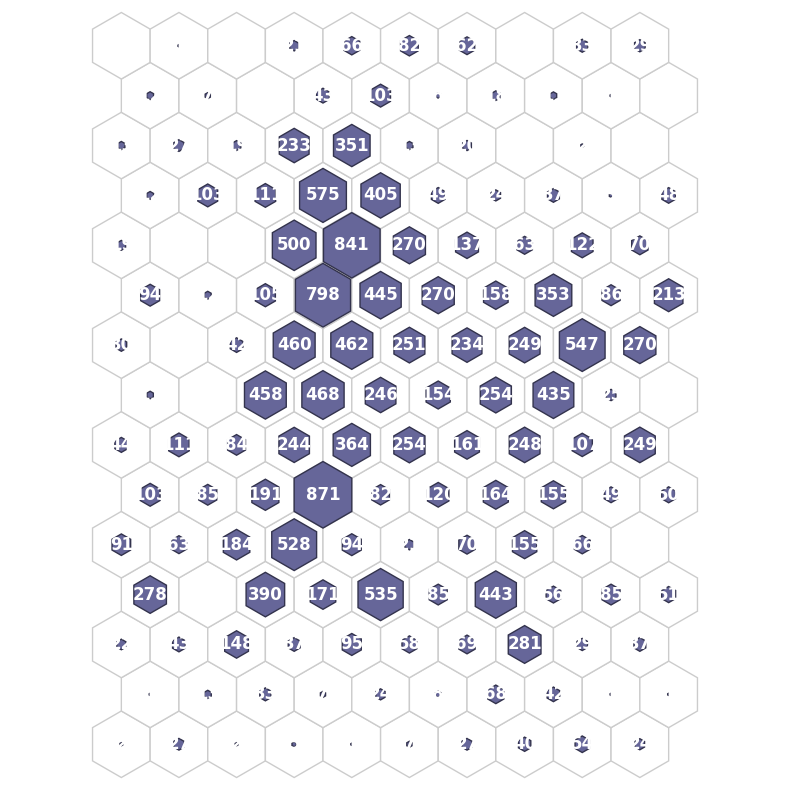

In [16]:
# Hit histogram
fig13, ax13, patches13, text13 = som_net.hit_hist(X, True)
plt.show()

In [ ]:
# Component Planes for the Trained SOM (Fig 26.6)